**1. Decision trees**

In [2]:
import pandas as pd
biden = pd.read_csv("biden.txt")
biden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 84.8 KB


**(a)**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import numpy as np
X = biden[["female","age","educ","dem","rep"]].values
y = biden["biden"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25) 
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

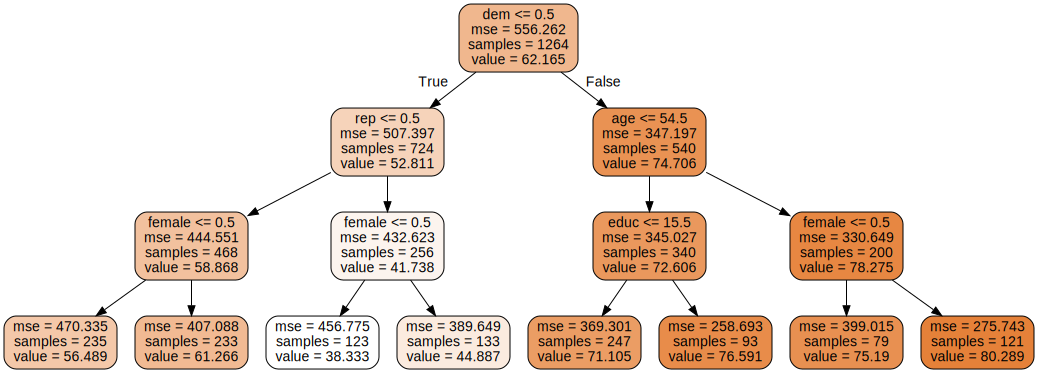

In [11]:
from sklearn.tree import export_graphviz
import graphviz
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names=["female","age","educ","dem","rep"],
    class_names=biden.biden,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

In [12]:
from sklearn.metrics import mean_squared_error
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('test MSE=', MSE1)

test MSE= 396.1937146321307


The binary decision tree splits the predictors into eight leaves. The mse on test set is around 396.19.
The first predictor is dem, which indicates affiliation with Democraticans. The left branch of the first node contains people who are not affiliated with Democratic Party and the right who are affiliated with Democratic Party. The second predictor of the left branch is rep, which indicates whether the respondent is affliated with Republicans.The following predictors have the similar mode.The mses in the final eight leaves are mainly between 35 and 85.  

**(b)**

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist1 = {'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20)}
random_search = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=param_dist1,
                                   n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
rs_fit1 = random_search.fit(X_train, y_train)
print(rs_fit1.best_params_)
print('MSE = ', abs(rs_fit1.best_score_))#best_score_ can be negative

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
MSE =  404.7488359884144


**(c)**

In [17]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
param_dist2 = {"n_estimators": [10, 200], 
               "max_depth": [3, 10], 
               "min_samples_split": sp_randint(2, 20), 
               "min_samples_leaf": sp_randint(2, 20), 
               "max_features": sp_randint(1, 5)}
random_search2 = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist2,
                                   n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
rs_fit2 = random_search2.fit(X_train, y_train)
print(rs_fit2.best_params_)
print('MSE = ', abs(rs_fit2.best_score_))#best_score_ can be negative

{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 17, 'min_samples_split': 12, 'n_estimators': 200}
MSE =  397.89422745189773


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**2. Classiﬁer “horse” race**

In [21]:
auto=pd.read_csv("Auto.csv", na_values='?')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [25]:
auto['mpg_high'] = (auto['mpg']>=auto['mpg'].median()).astype('int')
auto.dropna(inplace=True)
auto["orgn1"]=np.where(auto["origin"]==1,1,0)
auto["orgn2"]=np.where(auto["origin"]==2,1,0)
auto["constant"]=1
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2,constant
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0,1


**(a)**

In [29]:
from sklearn.linear_model import LogisticRegression 
yvals = auto["mpg_high"].values
Xvars=auto[["constant","cylinders","displacement","horsepower",
      "weight","acceleration","year","orgn1","orgn2"]].values
logit = LogisticRegression().fit(Xvars,yvals) 
logit.coef_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[-0.07294486, -0.09530101, -0.00121801, -0.07133085, -0.00331596,
        -0.19412659,  0.26596842, -0.34333934,  0.27100873]])

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
kf_log = KFold(n_splits=4, shuffle=True, random_state=25)
kf_log.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(4)

ytest_vec = np.zeros(auto.shape[0])
ypred_vec = np.zeros(auto.shape[0])
k_ind = int(0)

for train_index, test_index in kf_log.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    Logit = LogisticRegression()
    Logit.fit(X_train, y_train)
    y_pred = Logit.predict(X_test)
    ytest_vec[test_index] = y_test
    ypred_vec[test_index] = y_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('Test estimate MSE k-fold = {}.'.format(MSE_kf))
print(classification_report(ytest_vec, ypred_vec))

MSE for test set 0  is 0.14285714285714285
MSE for test set 1  is 0.09183673469387756
MSE for test set 2  is 0.07142857142857142
MSE for test set 3  is 0.08163265306122448
Test estimate MSE k-fold = 0.09693877551020408.
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       196
         1.0       0.89      0.92      0.90       196

   micro avg       0.90      0.90      0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Therefore, the error rate for mpg_high=0 is 1 - 0.92 = 0.08. The error rate for mpg_high=1 is 1 - 0.89 = 0.11.

**(b)**

In [36]:
param_dist3 = {"n_estimators": [10, 200], 
               "max_depth": [3, 8], 
               "min_samples_split": sp_randint(2, 20), 
               "min_samples_leaf": sp_randint(2, 20), 
               "max_features": sp_randint(1, 8)}
random_search3 = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist3,
                                   n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit3 = random_search3.fit(Xvars, yvals)
print(rs_fit3.best_params_)
print('MSE = ', abs(rs_fit3.best_score_))

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}
MSE =  0.09062757253378131


**(c)**

In [39]:
from scipy.stats import uniform as sp_uniform
from sklearn.svm import SVC 
param_dist4 = {"C": sp_uniform(loc=0.2, scale=4.0), 
               "gamma": ["scale", "auto"], 
               "shrinking": [True, False]}
random_search4 = RandomizedSearchCV(SVC(kernel='rbf'), param_distributions=param_dist4,
                                   n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit4 = random_search4.fit(Xvars, yvals)
print(rs_fit4.best_params_)
print('MSE = ', abs(rs_fit4.best_score_))

{'C': 1.1775180640974197, 'gamma': 'scale', 'shrinking': False}
MSE =  0.11734693877551021


**(d)**

Comparing the mse of each model, I think the random forest model is the best predictor of mpg high since its mse is around 0.090, which is the smallest.